<a href="https://colab.research.google.com/github/RedaGrace/Predict-Future-Sales/blob/main/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
transactions = pd.read_csv('sales_train.csv')
items        = pd.read_csv('items.csv') 
categories   = pd.read_csv('item_categories.csv')
shops        = pd.read_csv('shops.csv')
test         = pd.read_csv('test.csv')
submit_sample= pd.read_csv('sample_submission.csv')

In [6]:
#Data Downcasting

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [transactions, shops, items, categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [7]:
transactions.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,2935849,1034,28.12.2013,9434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2.93585e+06,NaN,NaN,NaN,14.5699,9.42299,0,7,14,23,33
shop_id,2.93585e+06,NaN,NaN,NaN,33.0017,16.227,0,22,31,47,59
item_id,2.93585e+06,NaN,NaN,NaN,10197.2,6324.3,0,4476,9343,15684,22169
item_price,2.93585e+06,NaN,NaN,NaN,890.623,1726.44,-1,249,399,999,307980
item_cnt_day,2.93585e+06,NaN,NaN,NaN,1.24264,2.61883,-22,1,1,1,2169


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int8   
 2   shop_id         int8   
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    int16  
dtypes: float32(1), int16(2), int8(2), object(1)
memory usage: 50.4+ MB


In [9]:
transactions.shape

(2935849, 6)

In [10]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1


In [11]:
items.describe(include='all')

,item_name,item_id,item_category_id
count,22170,22170.00000,22170.000000
unique,22170,NaN,NaN
top,КАМЕНЬ (BD),NaN,NaN
freq,1,NaN,NaN
mean,NaN,11084.50000,46.290753
std,NaN,6400.07207,15.941486
min,NaN,0.00000,0.000000
25%,NaN,5542.25000,37.000000
50%,NaN,11084.50000,40.000000
75%,NaN,16626.75000,58.000000


In [12]:
items.shape

(22170, 3)

In [13]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
categories.shape

(84, 2)

In [15]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [17]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
test.shape

(214200, 3)

# EDA

In [19]:
x = items.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.reset_index()
x.head()

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790


In [20]:
# no of sale by shop
y = transactions.groupby(['shop_id']).sum()
y = y.reset_index()
y.head()

,shop_id,date_block_num,item_id,item_price,item_cnt_day
0,0,5064.0,104811661.0,5553869.0,11705.0
1,1,2984.0,60950373.0,2926161.0,6311.0
2,2,433838.0,222177043.0,35104444.0,30620.0
3,3,406659.0,229674961.0,26472616.0,28355.0
4,4,554805.0,351785106.0,35335392.0,43942.0


In [21]:
# no of sale by price range
z = transactions.sort_values('item_price')
z = z.groupby(pd.cut(z['item_price'], np.arange(z['item_price'].min(), z['item_price'].max(), z['item_price'].max()/200))).sum()

z = z.rename({'item_price': 'price'}, axis=1)
z = z.iloc[0:20].reset_index()
z = z.rename({'item_price': 'price_range'}, axis=1)

z = z.reset_index()
z

,index,price_range,date_block_num,shop_id,item_id,price,item_cnt_day
0,0,"(-1.0, 1538.9]",35778296.0,83722794.0,2.703449e+10,1.227800e+09,3089859.0
1,1,"(1538.9, 3078.8]",5195640.0,10338979.0,2.229523e+09,7.246913e+08,433357.0
2,2,"(3078.8, 4618.7]",1184393.0,1656005.0,3.263717e+08,1.951775e+08,76458.0
3,3,"(4618.7, 6158.6]",155332.0,265271.0,6.110856e+07,4.599367e+07,10799.0
4,4,"(6158.6, 7698.5]",46156.0,82864.0,2.138838e+07,1.829672e+07,2965.0
5,5,"(7698.5, 9238.4]",56101.0,105877.0,3.091516e+07,2.828968e+07,4578.0
6,6,"(9238.4, 10778.3]",58062.0,122460.0,4.071124e+07,3.816480e+07,4584.0
7,7,"(10778.3, 12318.2]",17725.0,50963.0,1.853988e+07,1.828087e+07,1809.0
8,8,"(12318.2, 13858.1]",28983.0,96506.0,3.770542e+07,4.013901e+07,3275.0
9,9,"(13858.1, 15398.0]",53861.0,132653.0,4.709370e+07,5.750420e+07,4377.0


In [22]:
g = transactions.groupby(['date_block_num']).sum()
g = g.reset_index()
g.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,3417068.0,1.183972e+09,82211872.0,131479.0
1,1,3111582.0,1.076044e+09,75580184.0,128090.0
2,2,4016457.0,1.220912e+09,84298312.0,147142.0
3,3,3164978.0,9.713460e+08,61512824.0,107190.0
4,4,3093999.0,9.503730e+08,57274132.0,106970.0


Text(0.5, 1.0, 'Monthly sale')

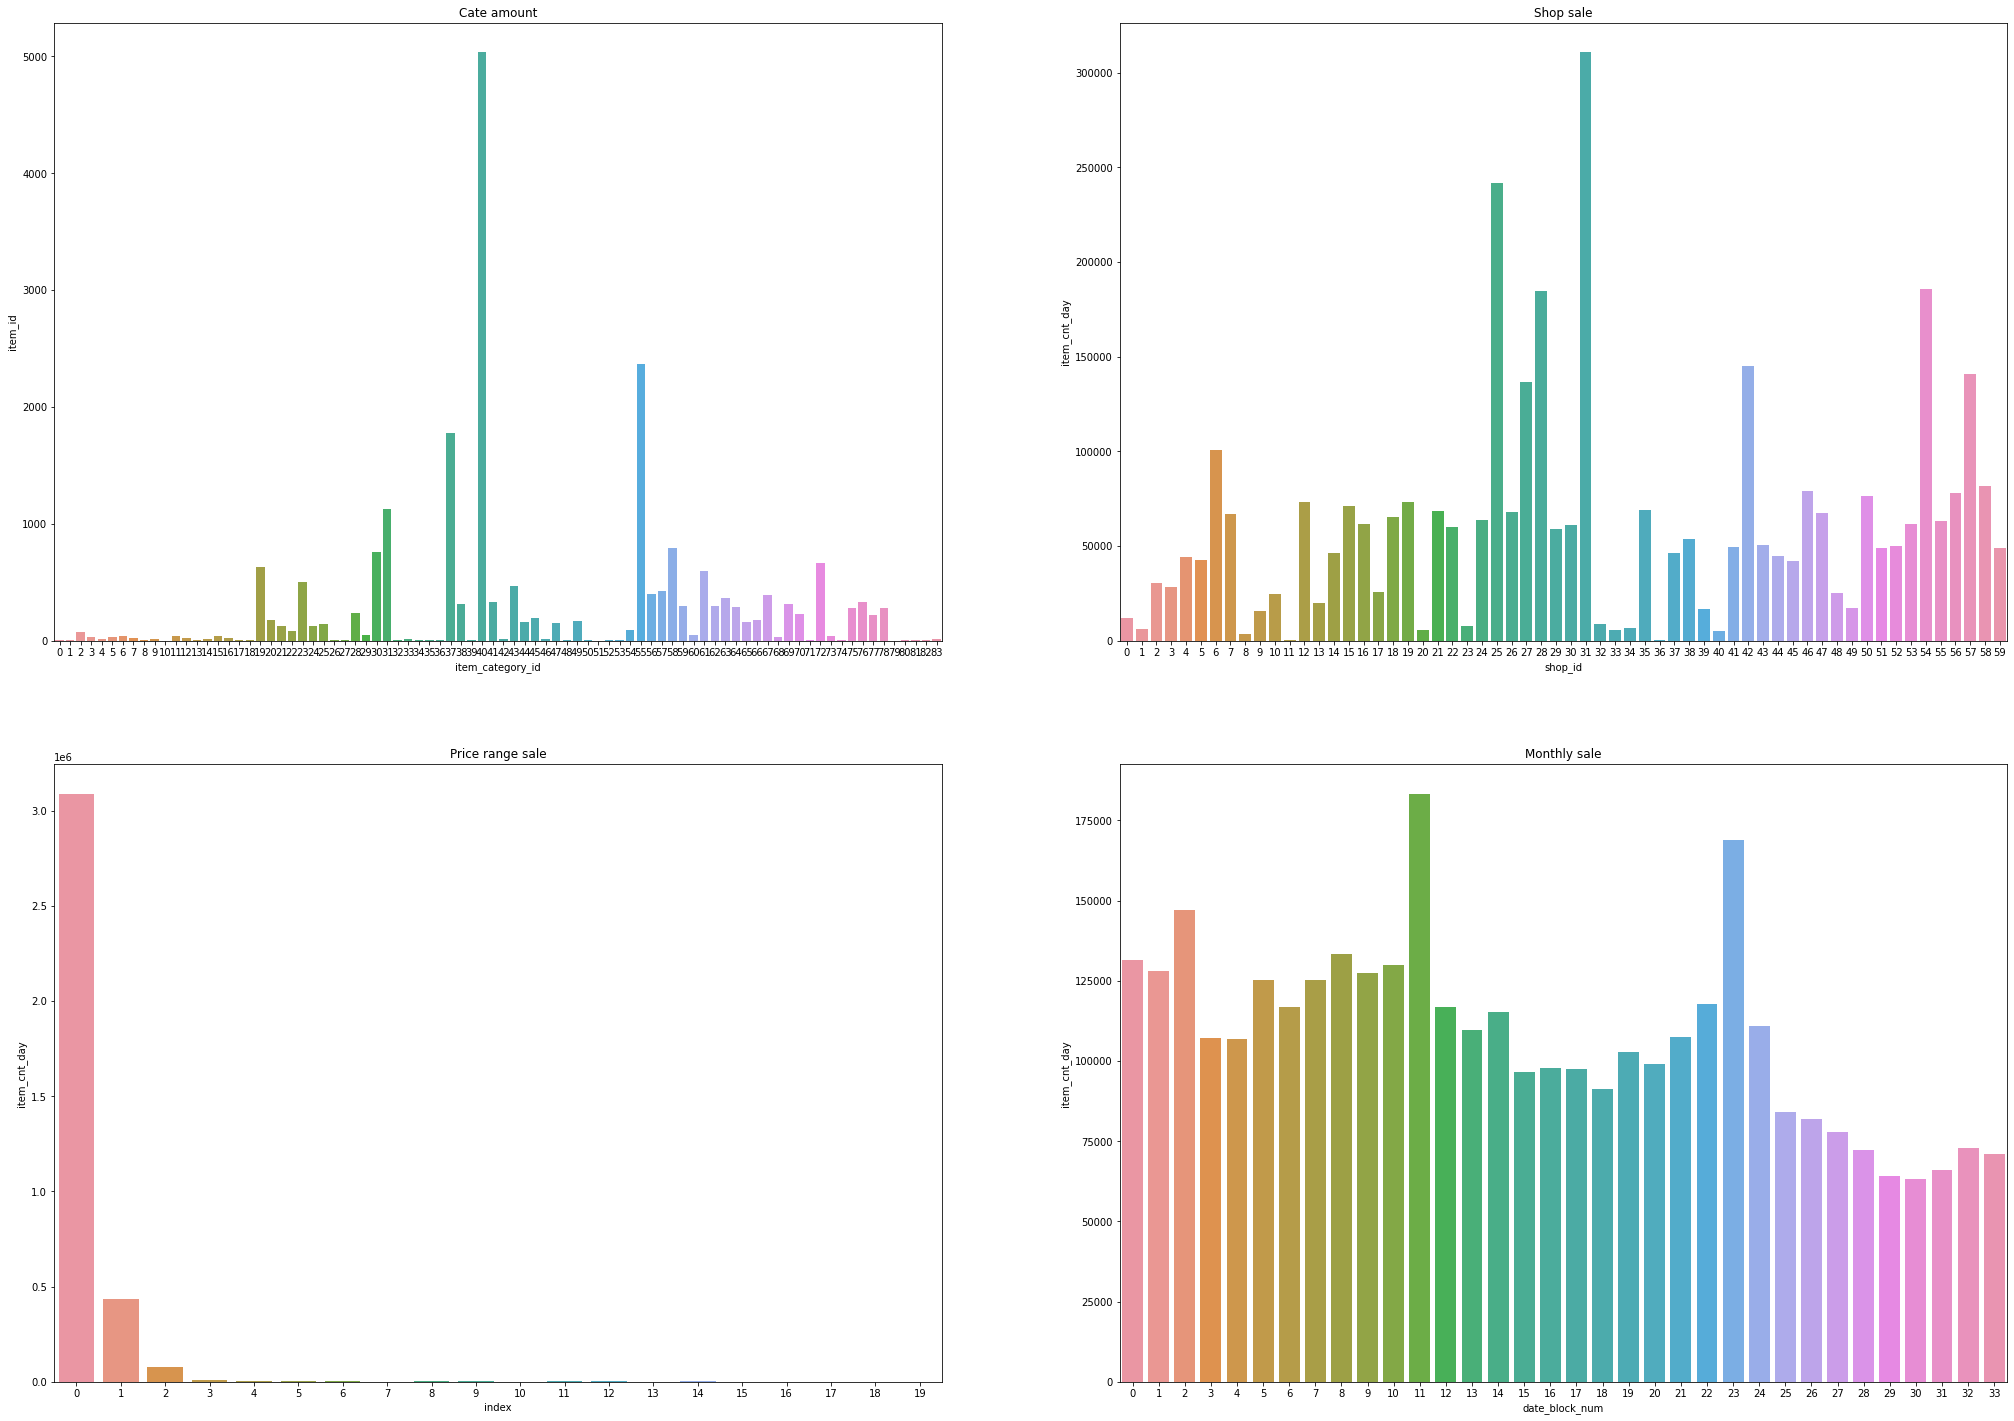

In [23]:
#visualization 

f, axes = plt.subplots(2,2, figsize=(35,25))

sns.barplot(x='item_category_id', y='item_id', data=x, ax=axes[0,0]).set_title('Cate amount')
sns.barplot(x='shop_id', y='item_cnt_day', data=y, ax=axes[0,1]).set_title('Shop sale')
sns.barplot(x='index', y='item_cnt_day', data=z, ax=axes[1,0]).set_title('Price range sale')
sns.barplot(x='date_block_num', y='item_cnt_day', data=g, ax=axes[1,1]).set_title('Monthly sale')

<Figure size 1440x720 with 0 Axes>

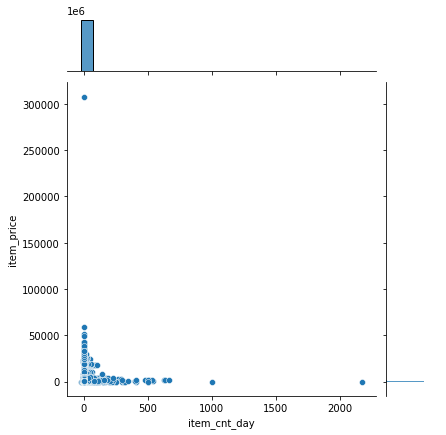

In [24]:
plt.figure(figsize=(20,10))
sns.jointplot(x='item_cnt_day', y='item_price', data=transactions)

In [25]:
a = transactions['item_price'].nlargest(50)
a = a.iloc[49,]
a

33490.0

In [26]:
h = transactions.groupby(pd.cut(transactions['item_price'], np.arange(transactions['item_price'].min(), a, a/300))).sum()
h['price_range']=np.arange(len(h))
h = h.iloc[0:20]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


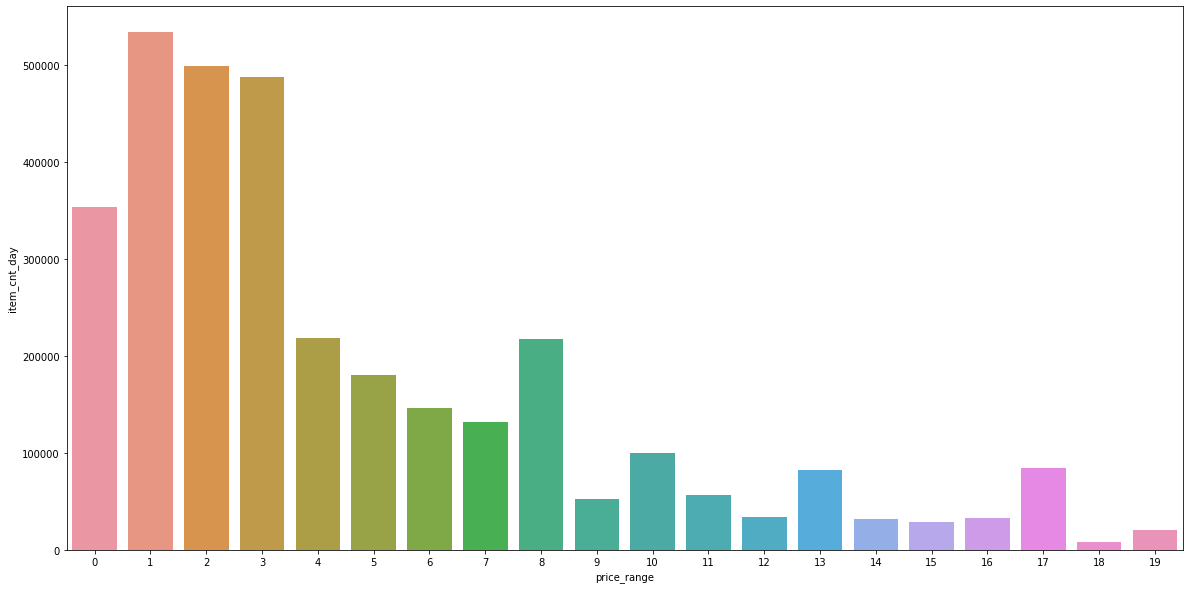

In [27]:
plt.figure(figsize=(20,10))
sns.barplot(h.price_range, h.item_cnt_day)

In [28]:
# Join data

full = transactions.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [29]:
full.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.623413,1726.439819,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0
item_category_id,2935849.0,40.001383,17.100759,0.0,28.0,40.0,55.0,83.0


In [30]:
full['revenue'] = full['item_cnt_day'] * full['item_price']
full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000


In [31]:
revenue_month = full.groupby(['date_block_num'], as_index=False).sum()
revenue_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,revenue
0,0,3417068.0,1.183972e+09,82211872.0,131479.0,4574740.0,91947088.0
1,1,3111582.0,1.076044e+09,75580184.0,128090.0,4319172.0,90665704.0
2,2,4016457.0,1.220912e+09,84298312.0,147142.0,4777604.0,104932688.0
3,3,3164978.0,9.713460e+08,61512824.0,107190.0,3804157.0,69154288.0
4,4,3093999.0,9.503730e+08,57274132.0,106970.0,3694879.0,65065312.0


Text(0.5, 1.0, 'Monthly Revenue')

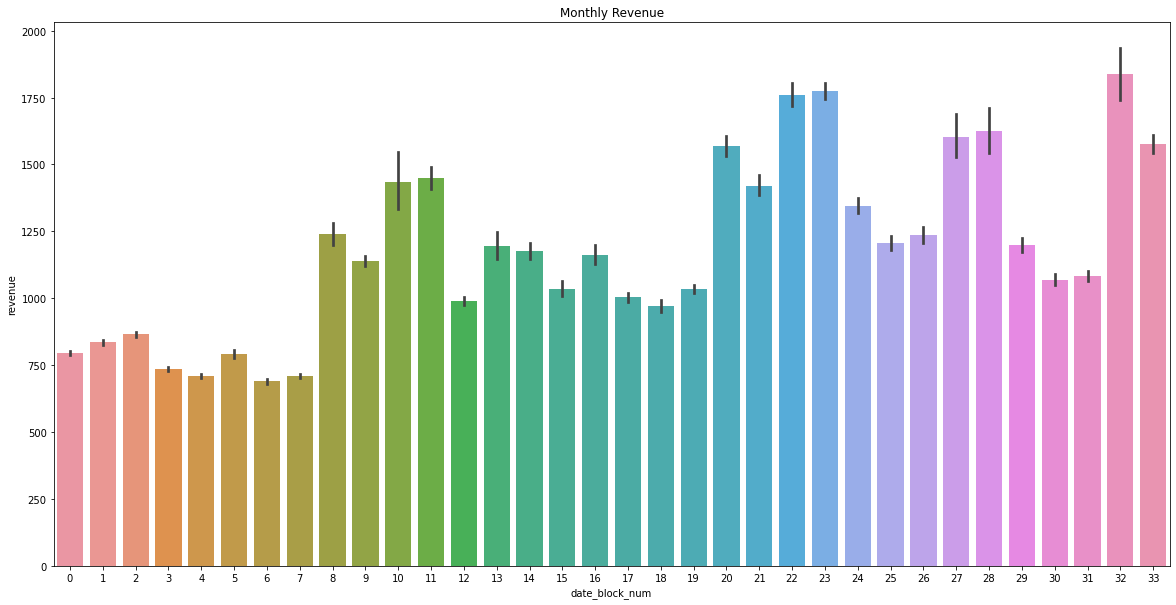

In [32]:
plt.figure(figsize=(20,10))
sns.barplot(x=full.date_block_num, y=full.revenue).set_title('Monthly Revenue')

In [33]:
# change time format to do comparison 
full['year'] = full['date_block_num'].apply(lambda x: ((x//12) + 2013))
full['month'] = full['date_block_num'].apply(lambda x: (x %12) +1 )
full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue,year,month
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000,2013,1
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000,2013,1
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000,2013,1
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049,2013,1
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000,2013,1


In [34]:
month = full[['month', 'year', 'item_cnt_day']]
month = month.sort_values(['month'])
month

,month,year,item_cnt_day
0,1,2013,1
2349317,1,2015,1
2349318,1,2015,1
2349319,1,2015,2
2349320,1,2015,1
...,...,...,...
2297349,12,2014,1
2297350,12,2014,3
2297351,12,2014,1
2297353,12,2014,1


In [35]:
month_pivot = month.pivot_table(index='month', columns='year', values='item_cnt_day')
month_pivot

year,2013,2014,2015
month,,,
1,1.136477,1.176650,1.253598
2,1.179325,1.221051,1.172543
3,1.212572,1.243322,1.172014
4,1.138998,1.239391,1.383001
5,1.165771,1.245272,1.325346
6,1.248777,1.182276,1.173884
7,1.163285,1.158964,1.137500
8,1.195844,1.185963,1.158691
9,1.386896,1.356097,1.439926


In [36]:
full

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue,year,month
0,02.01.2013,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.000000,2013,1
1,03.01.2013,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.000000,2013,1
2,05.01.2013,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.000000,2013,1
3,06.01.2013,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.050049,2013,1
4,15.01.2013,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.000000,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,299.000000,2015,10
2935845,09.10.2015,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,299.000000,2015,10
2935846,14.10.2015,33,25,7459,349.000000,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,349.000000,2015,10
2935847,22.10.2015,33,25,7440,299.000000,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3,299.000000,2015,10


In [37]:
revenue_month = full[['month', 'year', 'revenue']]
revenue_pivot = revenue_month.pivot_table(index='month', columns='year', values='revenue')
revenue_pivot

year,2013,2014,2015
month,,,
1,794.771301,988.696655,1343.481812
2,834.759277,1195.938110,1205.908569
3,864.732422,1176.662109,1235.781250
4,734.831787,1035.244507,1603.810181
5,709.089172,1162.395264,1623.843872
6,792.311035,1003.161560,1197.392700
7,689.726318,971.151855,1069.430420
8,709.139526,1034.522095,1082.764282
9,1238.668701,1568.183472,1836.506104


Text(0.5, 1.0, 'Monthly revenue')

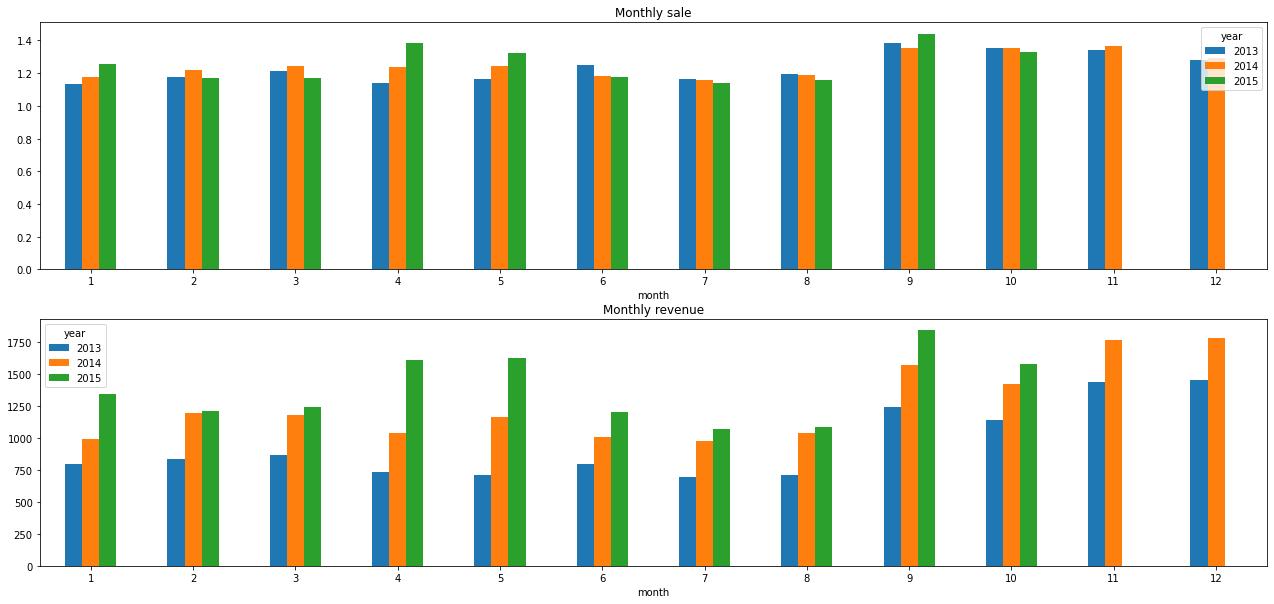

In [38]:
f, axes = plt.subplots(2, 1, figsize=(22,10))
month_pivot.plot(kind='bar', rot=0, ax=axes[0]).set_title('Monthly sale')                                       
revenue_pivot.plot(kind='bar', rot=0, ax=axes[1]).set_title('Monthly revenue') 

In [40]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1
2935845,09.10.2015,33,25,7460,299.000000,1
2935846,14.10.2015,33,25,7459,349.000000,1
2935847,22.10.2015,33,25,7440,299.000000,1


In [41]:
transactions.loc[transactions['shop_id'] == 1]['item_id'].value_counts()

14447    27
2931     25
4332     22
19811    21
2929     21
         ..
9031      1
7670      1
18634     1
1533      1
18495     1
Name: item_id, Length: 2523, dtype: int64

In [42]:
transactions.loc[transactions['shop_id'] == 58]['item_id'].value_counts()

20949    667
4870     338
12134    259
3077     251
4244     223
        ... 
16505      1
18552      1
18488      1
8245       1
12379      1
Name: item_id, Length: 8393, dtype: int64

In [43]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [44]:
#  Modify shop_id in sales_train data
transactions.loc[transactions['shop_id'] == 0, 'shop_id'] = 57
transactions.loc[transactions['shop_id'] == 1, 'shop_id'] = 58
transactions.loc[transactions['shop_id'] == 10, 'shop_id'] = 11
transactions.loc[transactions['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [45]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
transactions = transactions[transactions['shop_id'].isin(unique_test_shop_id)]

In [46]:
unique_test_shop_id

array([ 5,  4,  6,  3,  2,  7, 11, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 40, 45], dtype=int8)

In [47]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1
2935845,09.10.2015,33,25,7460,299.000000,1
2935846,14.10.2015,33,25,7459,349.000000,1
2935847,22.10.2015,33,25,7440,299.000000,1


In [48]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [49]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

In [50]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [51]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [52]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [53]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])
shops['city'] = pd.factorize(shops['city'])[0]

In [54]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0
2,"Адыгея ТЦ ""Мега""",2,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2
4,"Волжский ТЦ ""Волга Молл""",4,3


In [55]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


In [56]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [57]:
items

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


In [58]:
transactions.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

item_id
1        15
16       20
17       20
18       19
19        0
         ..
22165     7
22166     9
22167     8
22168     0
22169    14
Name: date_block_num, Length: 21086, dtype: int8

In [59]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = transactions.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [60]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [61]:
transactions.date_block_num.max()

33

In [62]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(-1)

In [63]:
categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [64]:
# Extract the first word of the item_categories_name into category
categories['category'] = categories['item_category_name'].apply(lambda x: x.split()[0])  

In [65]:
categories['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Чистые         2
Служебные      2
Элементы       1
Доставка       1
PC             1
Билеты         1
Name: category, dtype: int64

In [66]:
def make_etc(x):
    if len(categories[categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
categories['category'] = categories['category'].apply(make_etc)

In [67]:
categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [68]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
categories['category'] = label_encoder.fit_transform(categories['category'])

# Remove item_category_name feature
categories = categories.drop('item_category_name', axis=1)

In [69]:
encoding = categories.groupby('category').size()
encoding = encoding/len(categories)
categories['category'] = categories.category.map(encoding)

In [70]:
categories.head()

,item_category_id,category
0,0,0.095238
1,1,0.083333
2,2,0.083333
3,3,0.083333
4,4,0.083333


In [71]:
#Generate data combinations and derived features

from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in transactions['date_block_num'].unique():
    all_shop = transactions.loc[transactions['date_block_num']==i, 'shop_id'].unique()
    all_item = transactions.loc[transactions['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [72]:
transactions.loc[transactions['date_block_num']==0, 'shop_id'].unique()

array([59, 25, 24, 19, 22, 18, 21, 28, 26,  4,  6,  2,  3,  7, 57, 58, 16,
       15, 11, 14, 12, 53, 31, 35, 56, 47, 50, 42, 52, 41, 38, 44, 37, 46,
       45], dtype=int8)

In [73]:
transactions.loc[transactions['date_block_num']==0, 'item_id'].unique()

array([22154,  2552,  2554, ...,   628,   631,   621], dtype=int16)

In [74]:
train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
8647104,33,21,7635
8647105,33,21,7638
8647106,33,21,7640
8647107,33,21,7632


In [75]:
group = transactions.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head(20)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN
5,0,59,2565,NaN,NaN
6,0,59,2572,NaN,NaN
7,0,59,2573,NaN,NaN
8,0,59,2574,2.0,399.0
9,0,59,2593,NaN,NaN


In [76]:
# Add a feature for the number of items sold
group = transactions.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
#del group, transactions
#gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [77]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [78]:
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [79]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
#del shops, items, categories
#gc.collect();

60.0% compressed


In [80]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [81]:
resumetable(all_data)

Data Shape: (8861309, 10)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.000000,0.000000,0.000000
shop_id,int8,0,42,59.000000,59.000000,59.000000
item_id,int16,0,21470,22154.000000,2552.000000,2554.000000
item_cnt_month,int16,0,415,1.000000,0.000000,0.000000
item_price_mean,float32,0,34252,999.000000,0.000000,0.000000
item_count,int8,0,40,1.000000,0.000000,0.000000
city,int8,0,28,30.000000,30.000000,30.000000
item_category_id,int8,0,84,37.000000,58.000000,58.000000
first_sale_date,int8,0,35,0.000000,0.000000,0.000000
category,float32,0,7,0.059524,0.071429,0.071429


In [82]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    #del group
    #gc.collect()
    
    return df, mean_features

In [83]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

In [84]:
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [85]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [86]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [87]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += i
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    #gc.collect()
    
    return df, lag_features_to_clip

In [88]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [89]:
all_data.head().T           

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,0.059524,0.071429,0.071429,0.071429,0.071429


In [90]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [91]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [92]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales         0.0
item_id_city_mean_sales    0.0
dtype: float32

In [93]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [94]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [95]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [96]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

### Other Features Engineering

In [97]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)
all_data['month'] = all_data['date_block_num']%12
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8033618 entries, 827691 to 8861308
Data columns (total 31 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   city                                      int8   
 5   item_category_id                          int8   
 6   category                                  float32
 7   item_cnt_month_lag1                       int8   
 8   item_cnt_month_lag2                       int8   
 9   item_cnt_month_lag3                       int8   
 10  item_count_lag1                           int8   
 11  item_count_lag2                           int8   
 12  item_count_lag3                           int8   
 13  item_price_mean_lag1                      float32
 1

In [98]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
#del all_data
#gc.collect();

In [99]:
X_train.head()

,date_block_num,shop_id,item_id,city,item_category_id,category,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_count_lag1,item_count_lag2,item_count_lag3,item_price_mean_lag1,item_price_mean_lag2,item_price_mean_lag3,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,item_cnt_month_lag_mean,lag_grad1,lag_grad2,brand_new,duration_after_first_sale,month
827691,3,25,8092,14,40,0.059524,1,4,0,1,4,0,149.0,149.0,0.0,0.666667,1.428571,0.0,1.000000,2.142857,0.0,1.087262,1.048394,0.0,1.666667,0.250000,0.0,0,3,3
827692,3,25,7850,14,30,0.166667,5,6,0,4,5,0,199.0,199.0,0.0,2.000000,3.114286,0.0,3.714286,2.285714,0.0,3.651685,2.276650,0.0,3.666667,0.833333,0.0,0,3,3
827693,3,25,8051,14,66,0.142857,0,0,0,0,0,0,0.0,0.0,0.0,0.027778,0.085714,0.0,0.000000,0.428571,0.0,1.827586,1.389474,0.0,0.000000,0.000000,0.0,0,3,3
827694,3,25,8088,14,55,0.071429,1,0,0,1,0,0,199.0,0.0,0.0,0.111111,0.085714,0.0,0.285714,0.000000,0.0,0.598291,0.562107,0.0,0.333333,0.000000,0.0,0,3,3
827695,3,25,8089,14,55,0.071429,0,0,0,0,0,0,0.0,0.0,0.0,0.361111,0.200000,0.0,0.571429,0.000000,0.0,0.598291,0.562107,0.0,0.000000,0.000000,0.0,0,3,3


In [100]:
y_train.head()

827691    3
827692    3
827693    3
827694    1
827695    1
Name: item_cnt_month, dtype: int8

In [101]:
X_test.clip(0, 20)

,date_block_num,shop_id,item_id,city,item_category_id,category,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_count_lag1,item_count_lag2,item_count_lag3,item_price_mean_lag1,item_price_mean_lag2,item_price_mean_lag3,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_mean_sales_lag1,item_id_city_mean_sales_lag2,item_id_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,item_cnt_month_lag_mean,lag_grad1,lag_grad2,brand_new,duration_after_first_sale,month
8647109,20,5,20,4,19,0.166667,0,3,1,0,3,1,0.0,20.0,20.0,0.595238,2.853658,2.000000,0.0,3.0,1.0,0.513699,0.835366,0.437870,1.333333,0.0,3.000000,0,14,10
8647110,20,5,20,4,20,0.071429,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.158209,0.215152,0.155620,0.000000,0.0,0.000000,0,20,10
8647111,20,5,20,4,19,0.166667,1,1,3,1,1,2,20.0,20.0,20.0,1.000000,3.634146,1.634146,1.0,1.0,3.0,0.513699,0.835366,0.437870,1.666667,1.0,0.333333,0,7,10
8647112,20,5,20,4,20,0.166667,0,1,0,0,1,0,0.0,20.0,0.0,0.666667,1.560976,0.000000,0.0,1.0,0.0,0.374150,0.487179,0.342282,0.333333,0.0,0.000000,0,3,10
8647113,20,5,20,4,20,0.166667,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.796460,1.000000,0.905263,0.000000,0.0,0.000000,0,20,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8861304,20,20,20,20,20,0.071429,1,0,0,1,0,0,20.0,0.0,0.0,0.047619,0.073171,0.585366,0.5,0.0,0.0,0.126866,0.106061,0.128242,0.333333,0.0,0.000000,0,11,10
8861305,20,20,20,20,20,0.142857,0,0,0,0,0,0,0.0,0.0,0.0,0.023810,0.000000,0.000000,0.0,0.0,0.0,0.094488,0.220000,0.102041,0.000000,0.0,0.000000,0,2,10
8861306,20,20,20,20,20,0.071429,0,0,0,0,0,0,0.0,0.0,0.0,0.119048,0.097561,0.243902,0.0,0.0,0.0,0.126866,0.106061,0.128242,0.000000,0.0,0.000000,0,20,10
8861307,20,20,20,20,20,0.059524,0,0,0,0,0,0,0.0,0.0,0.0,0.047619,0.146341,0.097561,0.0,0.0,0.0,0.083756,0.112455,0.083426,0.000000,0.0,0.000000,0,11,10


# Train model and Submit

In [104]:

import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 273,
          'learning_rate': 0.007,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)    

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'city', 'item_category_id', 'month', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 0.967399	valid_1's rmse: 0.877292
[200]	training's rmse: 0.869249	valid_1's rmse: 0.816034
[300]	training's rmse: 0.827664	valid_1's rmse: 0.798947
[400]	training's rmse: 0.804719	valid_1's rmse: 0.793943
[500]	training's rmse: 0.788914	valid_1's rmse: 0.793
[600]	training's rmse: 0.777341	valid_1's rmse: 0.793082
[700]	training's rmse: 0.76848	valid_1's rmse: 0.792608
[800]	training's rmse: 0.760928	valid_1's rmse: 0.792224
[900]	training's rmse: 0.754799	valid_1's rmse: 0.79214
[1000]	training's rmse: 0.7497	valid_1's rmse: 0.792396
Early stopping, best iteration is:
[855]	training's rmse: 0.757395	valid_1's rmse: 0.79208


In [105]:
preds = lgb_model.predict(X_test).clip(0,20)

In [107]:
submit_sample['item_cnt_month'] = preds
submit_sample.to_csv('submission.csv', index=False)